## Cuts and masks

Within *yuntu*, there are many ways to generate slices of data from time/frequency geometries within the coordinate reference system of any *Audio* and feature object. Using these tools, one can query acoustic information in a very similar way to geographic information, generating samples with points, lines and polygons for statistical analysis.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yuntu import Audio
from yuntu.core import geometry as geom

In [2]:
TEST_DATA_DIR = '../src/yuntu/tests/test_data'
SAMPLE_AUDIO = os.path.join(TEST_DATA_DIR, '20210804_055000.WAV')

In [3]:
audio = Audio(path=SAMPLE_AUDIO)
spec = audio.features.db_spectrogram()
nsamples = 500
buffer_size = [0.1,100]
random_points = [geom.Point(t,f) for t,f in zip(np.random.uniform(1,audio.duration-1,nsamples),
                                                np.random.uniform(500,(audio.samplerate/2)-500,nsamples))]

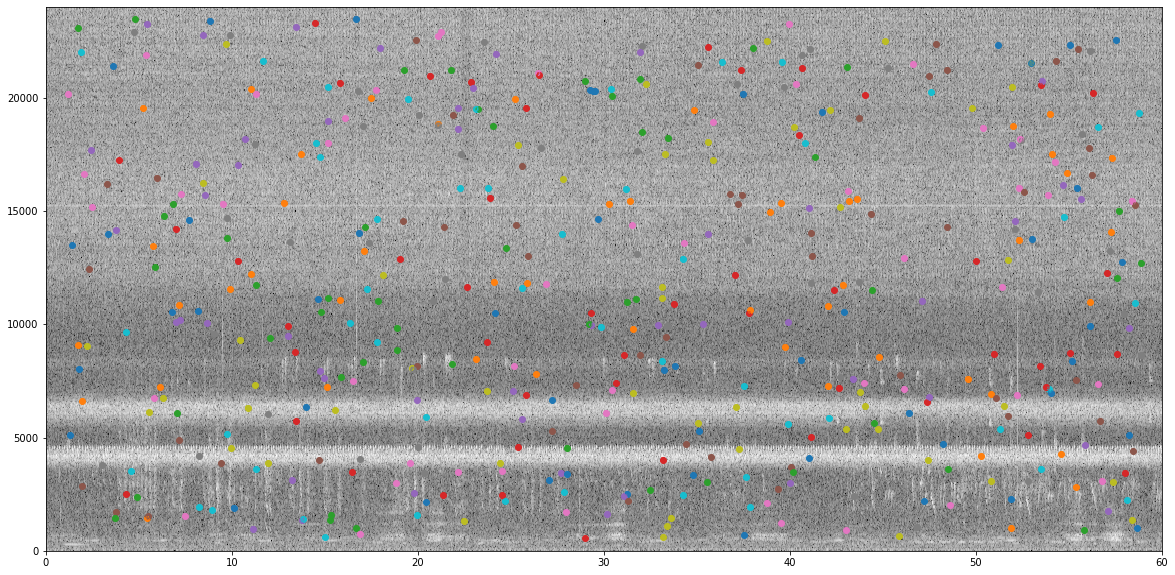

In [4]:
fig, ax = plt.subplots(figsize=(20,10),sharex=True)
spec.plot(ax=ax)
for point in random_points:
    point.plot(ax=ax)
    point.buffer(buffer_size).plot(ax=ax)

Using a geometry as an argument for *cut* in time-frequency media is equivalent to passing the bounding box limits in time and frequency as arguments. To produce a clip for *Audio* objects using a geometry that has a time component, one can use the argument *window*, passing the *window* attribute of the geometry. Another way to do so is getting the start time and end time of the geometry, which can be done using the geometry bounds or by creating a time interval with the method *to_time_interval* that any 2d geometry has (see plot below). Using the method *to_bbox* of 2d geometries yields a *BBbox* geometry tha represents its bounding box.

In [5]:
point = random_points[0]
point_buffer = point.buffer(buffer_size)
# Create a buffer that is slightly larger than the original buffer
context_buffer = point_buffer.buffer([0.2,200])
scut = spec.cut(geometry=context_buffer)
# Cut audio from context buffer window
acut = audio.cut(window=context_buffer.window)
# Create a ring from bondary
ring = geom.Geometry.from_geometry(point_buffer.geometry.boundary)
# Create a bounding box from geometry
bbox = point_buffer.to_bbox()

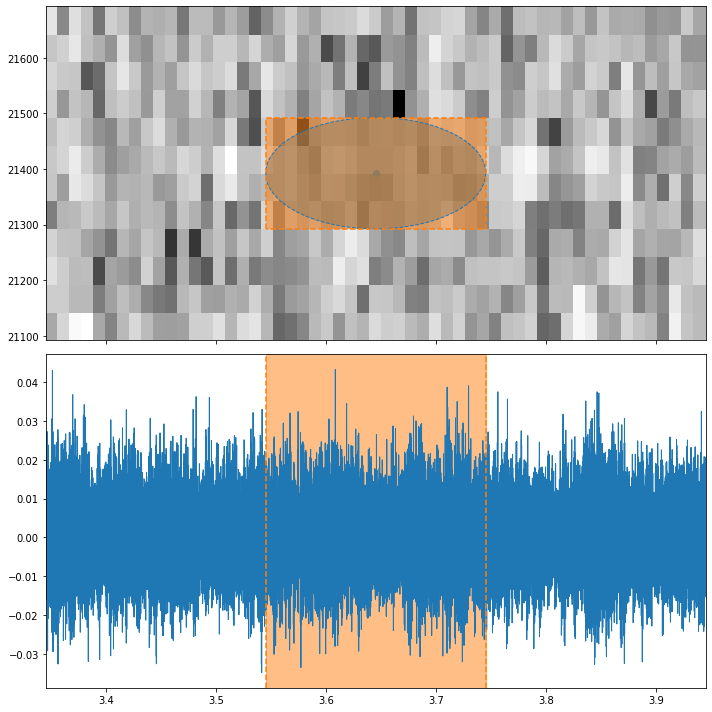

In [6]:
fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True)

# Plot spectrogram within limits with geometries
scut.plot(ax[0])
point.plot(ax=ax[0])
point_buffer.plot(ax=ax[0])
bbox.plot(ax=ax[0])

# Plot original 1d signal
acut.plot(ax=ax[1])
# Plot geometry as time interval projection with waveform
point_buffer.to_time_interval().plot(ax=ax[1])
plt.tight_layout()

Any geometry can be used to create masks that act as filters for media arrays using the method *to_mask* and passing the geometry as an argument. Masked objects are also useful for the generation of segmentation examples, where boolean arrays of event localization are used as labels. These types of objects have special plot methods for data representation that wrap masked plotting of media.

In [7]:
point_buffer_mask = scut.to_mask(point_buffer)
bbox_mask = scut.to_mask(bbox)
ring_mask = scut.to_mask(ring)
ring_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, Fa

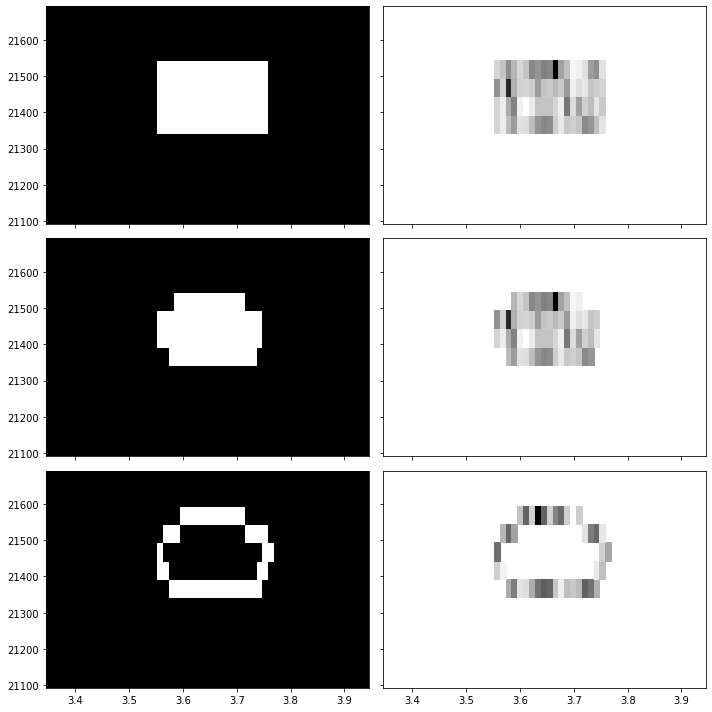

In [8]:
fig, ax = plt.subplots(3,2,figsize=(10,10), sharex=True, sharey=True)

# Plot bbox mask only
bbox_mask.plot(ax=ax[0][0])
# Plot bbox mask overlay
bbox_mask.plot(ax=ax[0][1], mask=False, media=True)

# Plot point buffer mask only
point_buffer_mask.plot(ax=ax[1][0])
# Plot point buffer mask overlay
point_buffer_mask.plot(ax=ax[1][1], mask=False, media=True)

# Plot ring mask only
ring_mask.plot(ax=ax[2][0])
# Plot ring mask overlay
ring_mask.plot(ax=ax[2][1], mask=False, media=True)

plt.tight_layout()


The following is a simple example on how to use cut and masked objects to create energy samples from geometries. The method *get_value* of media objects is employed to get the energy measurement at each specific time and frequency point. We use masks to retrieve the mean energy of a neighbourhood that contains each point to compare it with the value of the energy at each center as well as values at the boundaries of the neighbourhood and the sorrounding bounding box.

In [9]:
data = []
with audio.features.spectrogram() as plain_spec:
    for p in random_points:
        pbuffer = p.buffer(buffer_size)
        pring = geom.Geometry.from_geometry(pbuffer.geometry.boundary)
        pbbox = pbuffer.to_bbox()
        context = pbuffer.buffer([0.1,100])
        with plain_spec.cut(geometry=context) as sc:
            mask = sc.to_mask(pbuffer)
            ring_mask = sc.to_mask(pring)
            bbox_mask = sc.to_mask(pbbox)
            center_value = sc.get_value(p.time, p.freq)**2
            mean_buffer_value = np.mean(sc[mask.array]**2)
            mean_ring_value = np.mean(sc[ring_mask.array]**2)
            mean_bbox_value = np.mean(sc[bbox_mask.array]**2)
            data.append({"geometry": p.to_dict(),
                         "center": center_value,
                         "bbox_mean": mean_bbox_value,
                         "buffer_mean": mean_buffer_value,
                         "ring_mean": mean_ring_value})
measr = pd.DataFrame(data)
measr

,geometry,center,bbox_mean,buffer_mean,ring_mean
0,"{'type': 'Point', 'time': 3.6450462542211746, ...",0.018432,0.022245,0.021891,0.018273
1,"{'type': 'Point', 'time': 57.304980310391294, ...",0.047543,0.022741,0.023277,0.020426
2,"{'type': 'Point', 'time': 44.443536054062335, ...",0.003386,0.010841,0.008595,0.011633
3,"{'type': 'Point', 'time': 10.323885169011383, ...",0.000119,0.023333,0.021430,0.023109
4,"{'type': 'Point', 'time': 35.59910022951981, '...",0.018262,0.018569,0.021110,0.017413
...,...,...,...,...,...
495,"{'type': 'Point', 'time': 7.183119729242191, '...",0.000190,0.004039,0.004337,0.005338
496,"{'type': 'Point', 'time': 30.12074176259616, '...",0.128183,0.253805,0.243193,0.270417
497,"{'type': 'Point', 'time': 45.28143891078288, '...",0.003598,0.020430,0.020046,0.021176
498,"{'type': 'Point', 'time': 9.674883846695572, '...",0.015869,0.033659,0.032241,0.029981


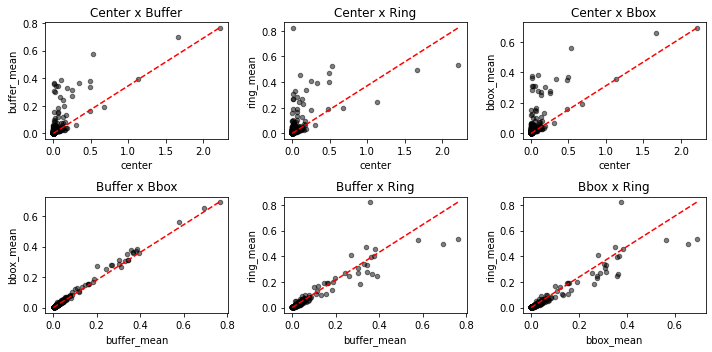

In [10]:
fig, ax = plt.subplots(2,3,figsize=(10,5))

buffer_mean_space=np.linspace(0, measr.buffer_mean.max(), 1000)
ring_mean_space=np.linspace(0, measr.ring_mean.max(), 1000)
bbox_mean_space=np.linspace(0, measr.bbox_mean.max(), 1000)
center_space=np.linspace(0, measr.center.max(), 1000)

measr.plot.scatter(x="center",y="buffer_mean", color="black", alpha=0.5, ax=ax[0][0])
ax[0][0].set_title("Center x Buffer")
ax[0][0].plot(center_space,buffer_mean_space,color="red", linestyle="--")

measr.plot.scatter(x="center",y="ring_mean", color="black", alpha=0.5, ax=ax[0][1])
ax[0][1].set_title("Center x Ring")
ax[0][1].plot(center_space,ring_mean_space,color="red", linestyle="--")

measr.plot.scatter(x="center",y="bbox_mean", color="black", alpha=0.5, ax=ax[0][2])
ax[0][2].set_title("Center x Bbox")
ax[0][2].plot(center_space,bbox_mean_space,color="red", linestyle="--")

measr.plot.scatter(x="buffer_mean",y="bbox_mean", color="black", alpha=0.5, ax=ax[1][0])
ax[1][0].set_title("Buffer x Bbox")
ax[1][0].plot(buffer_mean_space,bbox_mean_space,color="red", linestyle="--")

measr.plot.scatter(x="buffer_mean",y="ring_mean", color="black", alpha=0.5, ax=ax[1][1])
ax[1][1].set_title("Buffer x Ring")
ax[1][1].plot(buffer_mean_space,ring_mean_space,color="red", linestyle="--")

measr.plot.scatter(x="bbox_mean",y="ring_mean", color="black", alpha=0.5, ax=ax[1][2])
ax[1][2].set_title("Bbox x Ring")
ax[1][2].plot(bbox_mean_space,ring_mean_space,color="red", linestyle="--")

plt.tight_layout()

Combining geometry tools with audio dataframe accessors can produce complex profiling pipelines for acoustic data as well as dataset generators for machine learning.